In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Linear and Logistic Regression

### A. Optimization Routines and Loss Functions

In [2]:
class Functions:
    
    ## function for random sampling of data
    def random_sampler(self, perc=0.1):
        prop = int(len(self.X)*perc) #proportion of the data to be used for each iteration, here we have set it to 10% of the data
        ind = np.random.choice(range(len(self.X)), prop, replace=False)
        test_ind = list(set(range(len(self.X))) - set(ind)) #for using the rest sample as test set
        return self.X[ind],self.y[ind], self.X[test_ind], self.y[test_ind]
    
    ## funtion for normalizing the features
    def normalize_features(self,X,append=True):
        X = (X - np.mean(X, 0)) / np.std(X, 0) #normalize the features
        if append:
            X = np.append(np.ones(X.shape[0]).reshape(-1,1),X,1) #append column of ones for intercept
        return X
    
    ## for calculating the metrics
    def calculate_metrics(self, y, preds):
        
        ## accuracy is given by
        accuracy = 1-np.sum(np.abs(np.subtract(preds,y)))/len(preds)
        
        ## calculate the True Positives TP
        Tp = np.sum((y == True) & (preds == True))
        
        ## calculate the True Negatives TN
        Tn = np.sum((y == False) & (preds == False))
        
        ## calculate the False Positives FP
        Fp = np.sum((y == False) & (preds == True))
        
        ## calculate the False Negatives FN
        Fn = np.sum((y == True) & (preds == False))
        
        ## calculate the Precision P
        P = Tp/(Tp+Fp)
        
        ## calculate the Recall
        R = Tp/(Tp+Fn)
        
        ## calculate the F1 score
        F = 2/(1/P+1/R)
        
        ## making confusion matrix
        c = np.ones(4)
        c[0],c[1],c[2],c[3] = Tn, Fp, Fn, Tp
        c = c.reshape(2,2)
        
        return accuracy,P,R,F,c
    

In [3]:
class Optimization(Functions):
    
    ## initializing class
    def __init__(self, X, y, loss):
        self.X = X
        self.y = y
        self.loss = loss
    
    ## stochastic gradient descent function
    def SGD(self, B, max_iter=1000,tolerance=1e-6,lr=0.001):
        #function for updating parameters using SGD
        loss_list = []
        test_loss_list=[]
        for it in range(max_iter):
            #sample a random x and y batch for training and validation
            x, y, x_test,y_test = self.random_sampler()
            
            #calculating the loss
            curr_loss, derv_loss, _ = self.loss(self, x, y, B)
            loss_list.append(curr_loss)
            
            curr_loss_test, _, _ = self.loss(self, x_test, y_test, B)
            test_loss_list.append(curr_loss_test)
            
            #update the betas
            e = lr*derv_loss
            B = B - e
            
            #stop loop once updation becomes insignificant
            if np.all(np.abs(e) < tolerance):
                break
        return B,loss_list,test_loss_list
    
    ## Newton Method for Optimization
    def newton_optimization(self, B, max_iter=100, tolerance = 1e-4, lr=0.001):
        ## function for updating parameters using newton's method
        loss_list = []
        test_loss_list=[]
        x, y, x_test, y_test = self.random_sampler(perc = 0.80) # use 80-20 in the training too
        
        for it in range(max_iter):
            #calculate training loss
            curr_loss, gradient, hessian = self.loss(self, x, y, B)
            loss_list.append(curr_loss)
            
            #calculate test loss
            curr_loss_test, _, _ = self.loss(self, x_test, y_test, B)
            test_loss_list.append(curr_loss_test)
            
            ## newton method
            e = -np.linalg.solve(hessian,gradient)
            B = B + lr*e
            
            #stop loop once updation becomes insignificant
            if np.all(np.abs(e) < tolerance):
                break
                
        return B,loss_list,test_loss_list

In [4]:
class Loss():
    ## mean square error loss which returns loss, first derivative and hessian
    def mean_square_loss(self, X, y, betas):
        N = len(X)
        pred = np.dot(X,betas)
        return (np.square(y-pred)).mean(), (-2.0 /N) * X.T.dot(y - X.dot(betas)), 1/N * np.matmul(X.T,X)
    
    ## cross entropy loss
    def cross_entropy_loss(self, X, y, B):
        N = len(X)
        p = 1./(1+np.exp(-np.dot(X,B)))
        W = np.diag((p*(1-p)).reshape(-1))
        return (-1/N * (np.dot(y.T,np.log(p))+np.dot(np.transpose(1-y),np.log(1-p))))[0][0], -np.dot(X.T,(y-p)), X.T@W@X

In [5]:
class LinearRegression():
    #initialization of class
    def __init__ (self, X, y):
        self.X = X
        self.y = y.reshape(-1,1)
    
    ## function for fitting the model    
    def fit(self, max_iter=100, tolerance=1e-6, lr=0.1):
        
        # generate a random Beta matrix for 1st iteration
        B = np.zeros((self.X.shape[1],1))

        #define optimizer
        optim = Optimization(self.X, self.y, Loss.mean_square_loss)
        B, loss, test_loss = optim.SGD(B, max_iter, tolerance, lr)
        self.B = B
        return B,loss,test_loss
        
    def predict(self,X):
        return np.matmul(X,self.B)

## B. Fitting a Linear Regression Model using a Mean Square Loss and SGD

In [6]:
reg_data = pd.read_csv('regression.csv')
X,y = reg_data.iloc[:,:-1].values,reg_data.iloc[:,-1].values

In [7]:
## let's split the data into a training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train_normalized = Functions().normalize_features(X_train)
X_test_normalized = Functions().normalize_features(X_test)
lin_reg_model=LinearRegression(X_train_normalized,y_train)

In [9]:
lin_reg_model_params,train_loss,test_loss = lin_reg_model.fit()

Let's plot the training and testing loss

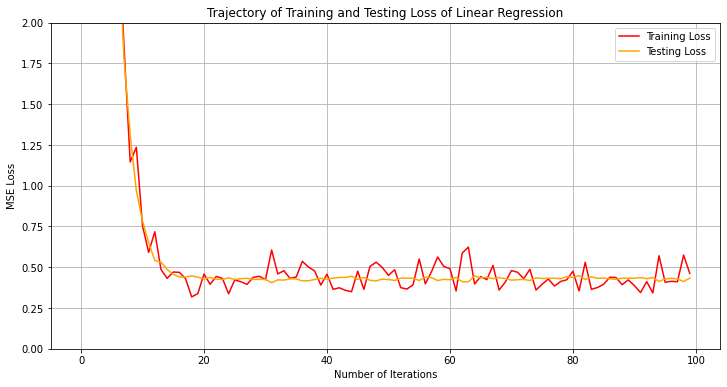

In [10]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss)),test_loss,color='orange',label='Testing Loss')
plt.ylim([0,2]);
plt.title('Trajectory of Training and Testing Loss of Linear Regression');
plt.xlabel('Number of Iterations');
plt.ylabel('MSE Loss');
plt.legend();
plt.grid('on');

let's compare our model with sklearn implementation of Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
sklearn_reg = LinearRegression()
sklearn_reg.fit(X_train_normalized[:,1:],y_train)

LinearRegression()

In [12]:
#sklearn returns coef and intercept differently let's append them
sklearn_reg_params = np.append(sklearn_reg.intercept_,sklearn_reg.coef_)

Let's compare the mean_squared_error obtained on test set in case of both sklearn linear regression and our model

In [13]:
lin_reg_preds = lin_reg_model.predict(X_test_normalized)
sklearn_preds = sklearn_reg.predict(X_test_normalized[:,1:])
lin_reg_loss, _, _ = Loss().mean_square_loss(X_train_normalized, y_train, lin_reg_model_params)
sklearn_reg_loss, _, _ = Loss().mean_square_loss(X_train_normalized, y_train, sklearn_reg_params)
print('The loss of our implementation is:',lin_reg_loss)
print('The loss of Sklearn Implementation is',sklearn_reg_loss)

The loss of our implementation is: 0.9093510305105057
The loss of Sklearn Implementation is 0.4241911573139901


**Question:** It is well known that deep neural networks do not function if the model parameters are initialised to
zero. Why is it so?

**Answer:**
If the weights of a NN is initialized with zero or in fact with any constant value, all the neurons will learn the same features. This will happen because the derivative will remain same for all the weights and there won't be any symmetry breaking.

**Question:**
Does this issue also arise while optimising the loss function for Linear or Logistic Regression?

**Answer:**
The loss function for the case of Linear and Logisitc Regression is convex, and for a convex function it does not matter from where we initialize the optimization, it has one global minima which is generally guarented to reached.

## C. Logistic Regression

In [14]:
class LogisticRegression():
    def __init__(self, X, y):
        self.X = X
        self.y = y.values.reshape(-1,1)
        
    def fit(self, max_iter= 100, tolerance=1e-6, lr=0.001):         
        # generate a random Beta matrix for 1st iteration
        B = np.zeros((self.X.shape[1],1)) 
        
        ## define optimizer
        optim = Optimization(self.X, self.y, Loss.cross_entropy_loss)
        B, loss, test_loss = optim.newton_optimization(B, max_iter, tolerance, lr)
        self.B = B
        return B,loss,test_loss
    
    def predict(self,X):
        scores = np.matmul(X,self.B)
        return 1./(1+np.exp(-scores))

In [15]:
## reading the data
log_reg_data = pd.read_csv('logistic.csv')

Let's replace the categorical variable with M being 1 and B being 0

In [16]:
log_reg_data['Y'] = log_reg_data['Y'].replace({'M':1,'B':0})

In [17]:
#splititng data into x and y
X = log_reg_data.iloc[:,1:]
y = log_reg_data.iloc[:,0]
## let's split the data into a training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train_normalized = Functions().normalize_features(X_train)
X_test_normalized = Functions().normalize_features(X_test)

In [19]:
# fitting the model
log_reg_model = LogisticRegression(X_train_normalized,y_train)
log_reg_model_params,train_loss,test_loss = log_reg_model.fit()

Let's see how well our model has fit the data by checking the test accuracy, precision, recall, F-score and confusion matrix

In [20]:
log_reg_model_preds = log_reg_model.predict(X_test_normalized)
accuracy,P,R,F,c = Functions().calculate_metrics(y_test,(log_reg_model_preds>0.5).reshape(-1))

In [21]:
print('The accuracy of the model is',accuracy)
print('The Precision of the model is',P)
print('The Recall of the model is',R)
print('The F-Score of the model is',F)
print('The Confusion Matrix formed by the model is \n',c)

The accuracy of the model is 0.9298245614035088
The Precision of the model is 0.9487179487179487
The Recall of the model is 0.8604651162790697
The F-Score of the model is 0.9024390243902437
The Confusion Matrix formed by the model is 
 [[69.  2.]
 [ 6. 37.]]


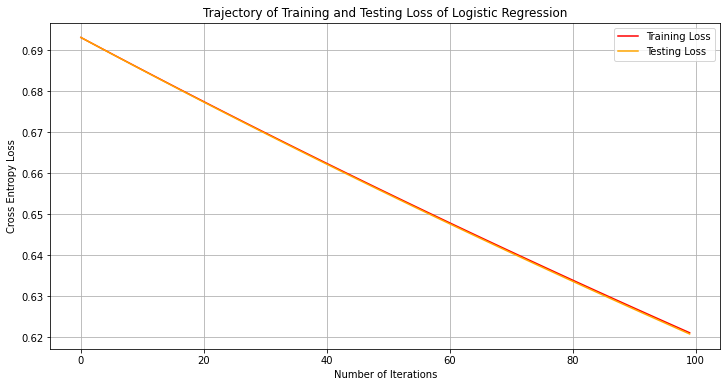

In [22]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_loss)),train_loss,color='red',label='Training Loss')
plt.plot(np.arange(len(test_loss)),test_loss,color='orange',label='Testing Loss')
plt.title('Trajectory of Training and Testing Loss of Logistic Regression');
plt.xlabel('Number of Iterations');
plt.ylabel('Cross Entropy Loss');
plt.legend();
plt.grid('on');

Let's compare our model with the Scikit learn Logistic Regression Model

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
logreg = LogisticRegression(solver='newton-cg')
logreg.fit(X_train_normalized[:,1:],y_train)

LogisticRegression(solver='newton-cg')

In [29]:
preds = logreg.predict(X_test_normalized[:,1:])

In [30]:
print(classification_report(y_test,preds),'\n',confusion_matrix(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114
 
 [[71  0]
 [ 2 41]]


Our model had the accuracy of 93% and sklearn implementation has gotten the accuracy of 98%

**Question:** Suppose model A and model B both have same accuracy, but model B has a higher
F-score, which model would be suited?

**Answer:** F1-score is the metric which captures the essence of both precision and recall and not highly effected by the class imbalance. The higher value of F1-score ensures good performance of the model over the range of confidence thresholds,therefore, model B is the better model.

## 2. Discriminant Analysis

In [31]:
from sklearn.datasets import load_iris

In [32]:
d = load_iris() #load the dataset
X = d.data #split independent variables separate
y = d.target #split target variables separate

In [33]:
class QDA:
    def __init__(self,X,y):
        #initializing the class
        self.X = X
        self.y = y
        self.classes = np.unique(self.y)
        self.num_classes = len(np.unique(self.y))
    
    #function to estimate the best parameters and make the model
    def fit(self):
        #first define the mean
        mean_k = [] #list that will store the mean of each class
        sigma_k = [] #list that will store the covariance matrix of each class
        pi_k = [] #list that will store the pi values for all the class K
        for k in self.classes: #iterating over each class and storing its estimates
            ind = self.y == k #indices where y belongs to class K
            xk = self.X[ind] #X's for class k
            mean_k.append(xk.mean(axis=0)) #mean with respect to class K
            sigma_k.append(np.cov(xk,bias=True,rowvar=False)) #covariance matrix with respect to class K
            pi_k.append(len(xk)/len(self.X)) #pi_k for the class K
        self.mean_k,self.sigma_k,self.pi_k = mean_k,sigma_k,pi_k
        return self.mean_k,self.sigma_k,self.pi_k
    
    #output the class of the data according to discriminant analysis
    def predict(self,X):
        mean_k,sigma_k,pi_k = self.mean_k,self.sigma_k,self.pi_k
        delta_k = [] #this will record the predicted class for each variable
        for x in X: #iterating over each observation 
            delta_x = [] #empty list to store delta_k for each observtion
            for k in range(self.num_classes): #iterating over each class
                diff = x - mean_k[k] 
                mahalanobis_distance = diff.T @ np.linalg.inv(sigma_k[k]) @ diff
                d = -1/2*np.log(np.linalg.det(sigma_k[k]))-1/2*mahalanobis_distance+np.log(pi_k[k])
                delta_x.append(d) #append the kth delta_k value of observation
            delta_k.append(np.argmax(delta_x)) #append all values of delta_k of each variable in a list
        return np.array(delta_k)

In [34]:
## let's split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
#define the model
qda_model = QDA(X_train,y_train)
#train it
qda_model.fit();

In [36]:
#obtaining predictions
qda_pred = qda_model.predict(X_test)

Similarly, let's make another class for LDA

In [37]:
class LDA:
    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.num_features = X.shape[1]
        self.num_classes = len(np.unique(self.y))
    
    #function to estimate the best parameters and make the model
    def fit(self):
        # since LDA is almost similar to QDA, we will estimate the parameters by using the QDA class
        qda = QDA(self.X,self.y)
        mean_k,sigma_k,pi_k = qda.fit()
        # now we will take the weighted sum of the cov matrix
        sigma = np.zeros(shape=(self.num_features,self.num_features))
        for k in range(self.num_classes):
            sigma = np.add(sigma,pi_k[k] * sigma_k[k])
        self.mean_k,self.sigma,self.pi_k = mean_k,sigma,pi_k
        return self.mean_k,self.sigma,self.pi_k
            
    
    #output the class of the data according to discriminant analysis
    def predict(self,X):
        mean_k,sigma,pi_k = self.mean_k,self.sigma,self.pi_k
        delta_k = [] #this will record the predicted class for each variable
        for x in X: #iterating over each observation 
            delta_x = [] #empty list to store delta_k for each observtion
            for k in range(self.num_classes): #iterating over each class
                diff = x - mean_k[k]
                mahalanobis_distance = diff.T @ np.linalg.inv(sigma) @ diff
                d = -1/2*np.log(np.linalg.det(sigma))-1/2*mahalanobis_distance+np.log(pi_k[k])
                delta_x.append(d) #append the kth delta_k value of observation
            delta_k.append(np.argmax(delta_x)) #append all values of delta_k of each variable in a list
        return np.array(delta_k)

In [38]:
#defining the model
lda_model = LDA(X_train,y_train)
#estimating the parameters
lda_model.fit()
#predicting on the test set
lda_pred = lda_model.predict(X_test)

In [39]:
#let's calculate the test accuracies of both LDA and QDA
def calculate_accuracy(true, pred):
    accuracy = np.sum(true == pred)/len(pred)
    #accuracy = 1-np.sum(np.abs(np.subtract(pred,true)))/len(pred)
    return np.round(accuracy,3)

In [40]:
print('The Test Accuracy of the QDA model is',calculate_accuracy(y_test,qda_pred))
print('The Test Accuracy of the LDA model is',calculate_accuracy(y_test,lda_pred))

The Test Accuracy of the QDA model is 0.967
The Test Accuracy of the LDA model is 1.0


Let's compare our results with the sklearn QDA, LDA implementation

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [42]:
sklearn_lda = LinearDiscriminantAnalysis()
sklearn_lda.fit(X_train,y_train)
sklearn_qda = QuadraticDiscriminantAnalysis()
sklearn_qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis()

In [43]:
print('The Test Accuracy of the Sklearn QDA model is',calculate_accuracy(y_test,sklearn_qda.predict(X_test)))
print('The Test Accuracy of the Sklearn LDA model is',calculate_accuracy(y_test,sklearn_lda.predict(X_test)))

The Test Accuracy of the Sklearn QDA model is 0.967
The Test Accuracy of the Sklearn LDA model is 1.0


This is exactly the same as our model which tells our implementation is correct.